In [1]:
from tensorflow import keras
from tensorflow.keras import layers

from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import time

physical_devices = tf.config.list_physical_devices('GPU') 
#for device in physical_devices:
#    tf.config.experimental.set_memory_growth(device, True)
    
#mirrored_strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


## Classifing data with ResNet50

### Create dataset

In [3]:
img_size = 64
num_classes = 25

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "aug-malevis",
    image_size=(img_size,img_size),
    batch_size=256,
    label_mode='categorical',
)

Found 24894 files belonging to 25 classes.


In [4]:
def get_dataset_partitions(ds, ds_size, train_split=0.7, val_split=0.1, test_split=0.2, shuffle=True, shuffle_size=10000): 
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(test_size)
    
    return train_ds, val_ds, test_ds

In [5]:
ds_size=tf.data.experimental.cardinality(dataset).numpy()

train_ds, val_ds, test_ds = get_dataset_partitions(dataset, ds_size)

train_ds = train_ds.map(lambda x, y: (tf.keras.applications.resnet.preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (tf.keras.applications.resnet.preprocess_input(x), y))
test_ds = test_ds.map(lambda x, y: (tf.keras.applications.resnet.preprocess_input(x), y))

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())
print(tf.data.experimental.cardinality(test_ds).numpy())

68
9
11


In [6]:
from tensorflow import keras

resNet=tf.keras.applications.ResNet152(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size,img_size,3),
)

resNet.trainable=False

model = keras.Sequential()
model.add(resNet)
model.add(layers.Flatten())
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 2, 2, 2048)        58370944  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1000)              8193000   
_________________________________________________________________
dense_1 (Dense)              (None, 25)                25025     
Total params: 66,588,969
Trainable params: 8,218,025
Non-trainable params: 58,370,944
_________________________________________________________________


In [7]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
#model.load_weights('best_resnet.h5')

In [8]:
tic = time.time()

#with mirrored_strategy.scope():
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc', 'Precision', 'Recall', 'AUC', f1_m])
    
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-3, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-3, verbose=1)
'''
best_resnet = tf.keras.callbacks.ModelCheckpoint(
                                          filepath='best_resnet.h5',
                                          save_weights_only=False,
                                          monitor='val_acc',
                                          mode='max',
                                          save_best_only=True)
'''

history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[early_stopping, reduce_lr])

print("Training time:", time.strftime("%H:%M:%S", time.gmtime(time.time() - tic)))

Epoch 1/100
68/68 [==============================] - 57s 398ms/step - loss: 1.1688 - acc: 0.8179 - precision: 0.8725 - recall: 0.7930 - auc: 0.9615 - f1_m: 0.8262 - val_loss: 0.2171 - val_acc: 0.9427 - val_precision: 0.9712 - val_recall: 0.9236 - val_auc: 0.9969 - val_f1_m: 0.9468
Epoch 2/100
68/68 [==============================] - 33s 292ms/step - loss: 0.1858 - acc: 0.9488 - precision: 0.9676 - recall: 0.9355 - auc: 0.9973 - f1_m: 0.9514 - val_loss: 0.1318 - val_acc: 0.9661 - val_precision: 0.9744 - val_recall: 0.9575 - val_auc: 0.9979 - val_f1_m: 0.9658
Epoch 3/100
68/68 [==============================] - 32s 292ms/step - loss: 0.1127 - acc: 0.9675 - precision: 0.9783 - recall: 0.9582 - auc: 0.9989 - f1_m: 0.9681 - val_loss: 0.0781 - val_acc: 0.9796 - val_precision: 0.9851 - val_recall: 0.9735 - val_auc: 0.9997 - val_f1_m: 0.9793
Epoch 4/100
68/68 [==============================] - 32s 293ms/step - loss: 0.0674 - acc: 0.9823 - precision: 0.9879 - recall: 0.9768 - auc: 0.9993 - f1_m

Training accuracy: 0.9964384436607361
Validation accuracy: 0.9947916865348816

Training loss: 0.011406085453927517
Validation loss: 0.020011670887470245


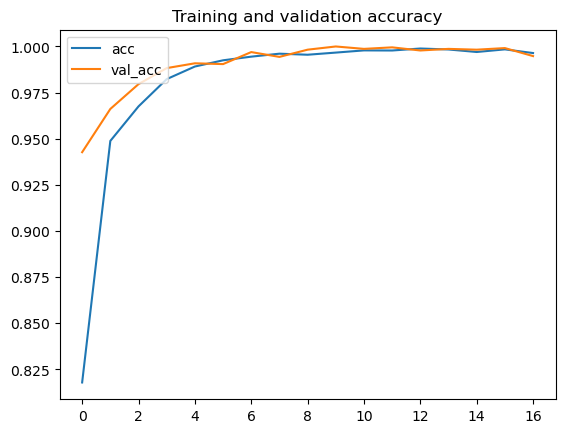

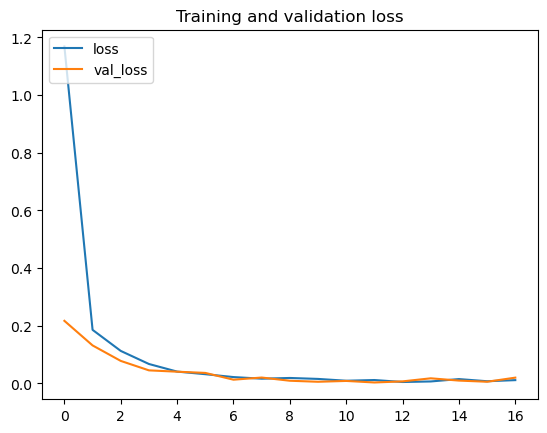

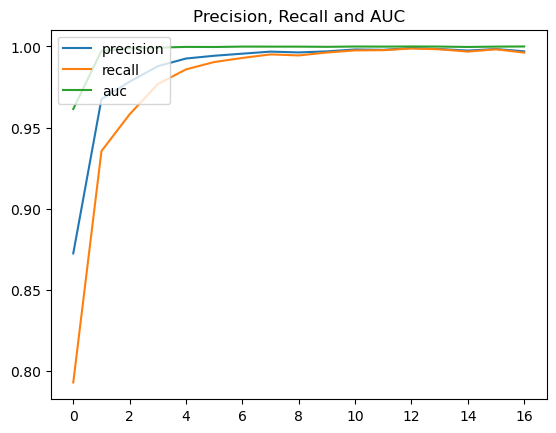

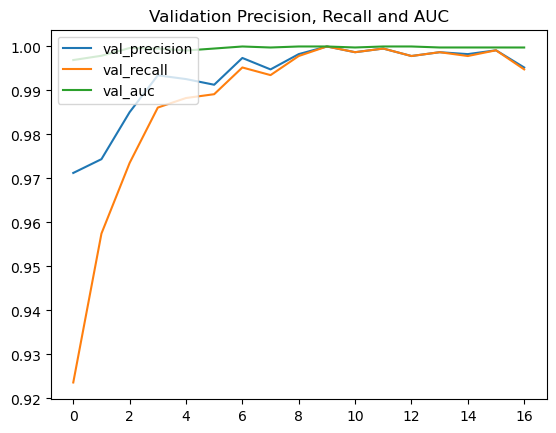

In [9]:
#Plot loss and accuracy as a function of the epoch, for the training and validation datasets.
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
prec = history.history['precision']
rec = history.history['recall']
auc = history.history['auc']
val_prec = history.history['val_precision']
val_rec = history.history['val_recall']
val_auc = history.history['val_auc']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.legend(['acc', 'val_acc'], loc='upper left')
print("Training accuracy:", acc[-1])
print("Validation accuracy:", val_acc[-1])
    
# Plot training and validation loss per epoch
plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.legend(['loss', 'val_loss'], loc='upper left')
print("\nTraining loss:", loss[-1])
print("Validation loss:", val_loss[-1])

plt.figure()
plt.plot(epochs, prec)
plt.plot(epochs, rec)
plt.plot(epochs, auc)
plt.title('Precision, Recall and AUC')
plt.legend(['precision', 'recall', 'auc'], loc='upper left')

plt.figure()
plt.plot(epochs, val_prec)
plt.plot(epochs, val_rec)
plt.plot(epochs, val_auc)
plt.title('Validation Precision, Recall and AUC')
plt.legend(['val_precision', 'val_recall', 'val_auc'], loc='upper left')
    
plt.show()

In [10]:
results = model.evaluate(test_ds)

11/11 [==============================] - 14s 91ms/step - loss: 0.0195 - acc: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9998 - f1_m: 0.9936


In [19]:
predict_malware = test_ds.unbatch().filter(lambda x, y: y == 1).batch(128)

preds = model.predict(predict_malware)

correct_preds = preds > 0.5
wrong_preds = preds < 0.5
num_positive_preds = np.sum(correct_preds)
num_negative_preds = np.sum(wrong_preds)
print('Numero di previsioni corrette:', num_positive_preds)
print('Numero di previsioni errate:', num_negative_preds)

Numero di previsioni corrette: 4649
Numero di previsioni errate: 4


In [18]:
predict_benign = test_ds.unbatch().filter(lambda x, y: y == 0).batch(128)

preds = model.predict(predict_benign)

correct_preds = preds < 0.5
wrong_preds = preds > 0.5
num_positive_preds = np.sum(correct_preds)
num_negative_preds = np.sum(wrong_preds)
print('Numero di previsioni corrette:', num_positive_preds)
print('Numero di previsioni errate:', num_negative_preds)

Numero di previsioni corrette: 142
Numero di previsioni errate: 40
